In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:

datasets = {
    'CEAS_08': pd.read_csv('../data/raw/CEAS_08.csv'),
    'Nazario': pd.read_csv('../data/raw/Nazario.csv'),
    'Nigerian_Fraud': pd.read_csv('../data/raw/Nigerian_Fraud.csv'),
    'SpamAssasin': pd.read_csv('../data/raw/SpamAssasin.csv')
}

combined_data = []

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Columns: {df.columns.tolist()}")
    print(f"  Shape: {df.shape}")
    
    # Only keep datasets with sender, receiver, and label
    if 'sender' in df.columns and 'receiver' in df.columns and 'label' in df.columns:
        temp = df[['sender', 'receiver', 'label']].copy()
        temp['dataset'] = name
        combined_data.append(temp)
        print(f"  ✓ Added to analysis")

df_combined = pd.concat(combined_data, ignore_index=True)

print(f"\n{'='*60}")
print(f"COMBINED DATA:")
print(f"  Total emails: {len(df_combined)}")
print(f"  Spam: {(df_combined['label'] == 1).sum()}")
print(f"  Ham: {(df_combined['label'] == 0).sum()}")
print(f"  Unique senders: {df_combined['sender'].nunique()}")
print(f"  Unique receivers: {df_combined['receiver'].nunique()}")


CEAS_08:
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
  Shape: (39154, 7)
  ✓ Added to analysis

Nazario:
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
  Shape: (1565, 7)
  ✓ Added to analysis

Nigerian_Fraud:
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
  Shape: (3332, 7)
  ✓ Added to analysis

SpamAssasin:
  Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
  Shape: (5809, 7)
  ✓ Added to analysis

COMBINED DATA:
  Total emails: 49860
  Spam: 28457
  Ham: 21403
  Unique senders: 31415
  Unique receivers: 6510


In [ ]:
# Clean the data (remove invalid entries)
df_combined = df_combined.dropna(subset=['sender', 'receiver'])
df_combined['sender'] = df_combined['sender'].astype(str).str.strip().str.lower()
df_combined['receiver'] = df_combined['receiver'].astype(str).str.strip().str.lower()

df_combined = df_combined[
    (df_combined['sender'] != 'nan') & 
    (df_combined['receiver'] != 'nan')
]

print(f"After cleaning: {len(df_combined)} emails")

G = nx.DiGraph()

print("\nBuilding graph...")
for idx, row in df_combined.iterrows():
    sender = row['sender']
    receiver = row['receiver']
    is_spam = row['label']
    
    # Add edge (or update if exists)
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += 1
        G[sender][receiver]['spam_count'] += is_spam
    else:
        G.add_edge(sender, receiver, 
                   weight=1, 
                   spam_count=is_spam,
                   ham_count=1-is_spam)

print(f"\n{'='*60}")
print(f"GRAPH BUILT:")
print(f"  Nodes (email addresses): {G.number_of_nodes()}")
print(f"  Edges (connections): {G.number_of_edges()}")
print(f"  Network density: {nx.density(G):.6f}")

After cleaning: 47481 emails

Building graph...

GRAPH BUILT:
  Nodes (email addresses): 34928
  Edges (connections): 35123
  Network density: 0.000029


In [16]:
# MUCH FASTER approach - vectorized operations
print("Extracting features (optimized)...")

# Pre-calculate all metrics at once
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())

sender_features = []

# Group by sender for faster processing
sender_groups = df_combined.groupby('sender')

for sender, group in sender_groups:
    if sender not in G:
        continue
    
    out_deg = out_degrees.get(sender, 0)
    if out_deg == 0:
        continue
    
    # Calculate metrics from the grouped data (much faster!)
    total_sent = len(group)
    spam_sent = group['label'].sum()
    spam_ratio = spam_sent / total_sent
    
    # Reciprocity (simplified)
    receivers = list(G.successors(sender))
    reciprocity = sum([1 for r in receivers if G.has_edge(r, sender)]) / len(receivers) if receivers else 0
    
    sender_features.append({
        'sender': sender,
        'out_degree': out_deg,
        'in_degree': in_degrees.get(sender, 0),
        'total_sent': total_sent,
        'spam_ratio': spam_ratio,
        'reciprocity': reciprocity,
        'is_spammer': 1 if spam_ratio > 0.8 else 0
    })

features_df = pd.DataFrame(sender_features)

print(f"\n{'='*60}")
print(f"FEATURES EXTRACTED:")
print(f"  Total senders: {len(features_df)}")
print(f"  Spammers (>80%): {(features_df['is_spammer'] == 1).sum()}")
print(f"  Legitimate (<80%): {(features_df['is_spammer'] == 0).sum()}")
print(f"\nTop features:")
print(features_df[['out_degree', 'reciprocity', 'spam_ratio']].describe())

Extracting features (optimized)...

FEATURES EXTRACTED:
  Total senders: 29955
  Spammers (>80%): 25298
  Legitimate (<80%): 4657

Top features:
         out_degree   reciprocity    spam_ratio
count  29955.000000  29955.000000  29955.000000
mean       1.172525      0.013035      0.844585
std        1.527063      0.103787      0.362265
min        1.000000      0.000000      0.000000
25%        1.000000      0.000000      1.000000
50%        1.000000      0.000000      1.000000
75%        1.000000      0.000000      1.000000
max       90.000000      1.000000      1.000000


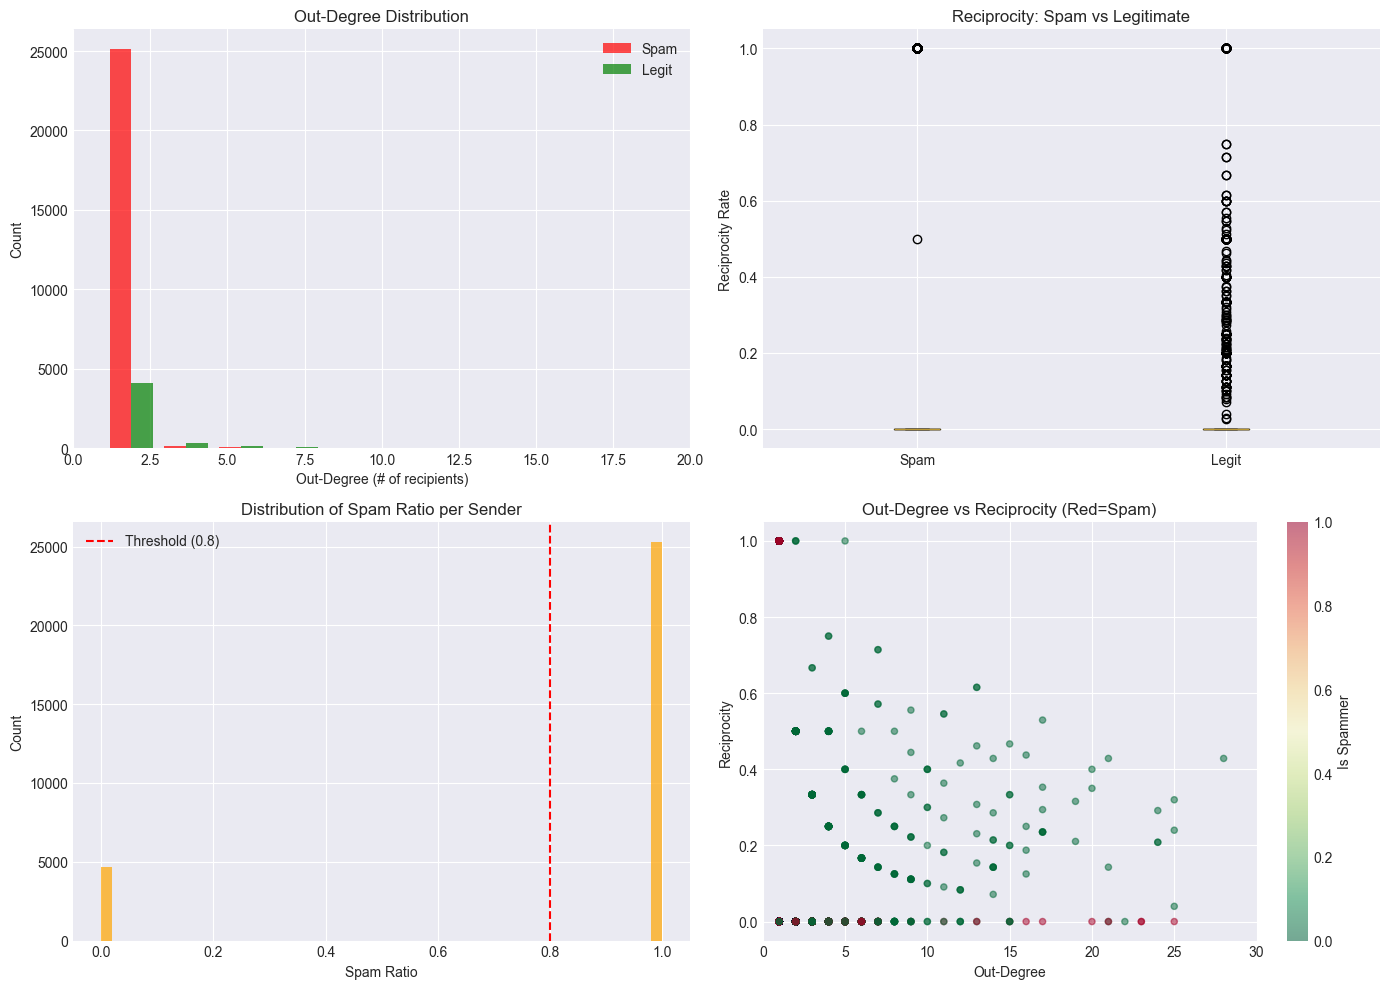


✅ Visualization saved as 'email_features_visualization.png'


In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Out-degree distribution (spam vs legit)
ax1 = axes[0, 0]
spam_senders = features_df[features_df['is_spammer'] == 1]
legit_senders = features_df[features_df['is_spammer'] == 0]

ax1.hist([spam_senders['out_degree'], legit_senders['out_degree']], 
         bins=50, label=['Spam', 'Legit'], alpha=0.7, color=['red', 'green'])
ax1.set_xlabel('Out-Degree (# of recipients)')
ax1.set_ylabel('Count')
ax1.set_title('Out-Degree Distribution')
ax1.legend()
ax1.set_xlim(0, 20)  # Focus on 0-20 for clarity

# 2. Reciprocity comparison
ax2 = axes[0, 1]
data_to_plot = [spam_senders['reciprocity'], legit_senders['reciprocity']]
ax2.boxplot(data_to_plot, labels=['Spam', 'Legit'])
ax2.set_ylabel('Reciprocity Rate')
ax2.set_title('Reciprocity: Spam vs Legitimate')

# 3. Spam ratio distribution
ax3 = axes[1, 0]
ax3.hist(features_df['spam_ratio'], bins=50, color='orange', alpha=0.7)
ax3.set_xlabel('Spam Ratio')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Spam Ratio per Sender')
ax3.axvline(x=0.8, color='red', linestyle='--', label='Threshold (0.8)')
ax3.legend()

# 4. Scatter: Out-degree vs Reciprocity (colored by spam)
ax4 = axes[1, 1]
scatter = ax4.scatter(features_df['out_degree'], 
                     features_df['reciprocity'],
                     c=features_df['is_spammer'], 
                     cmap='RdYlGn_r', 
                     alpha=0.5, 
                     s=20)
ax4.set_xlabel('Out-Degree')
ax4.set_ylabel('Reciprocity')
ax4.set_title('Out-Degree vs Reciprocity (Red=Spam)')
ax4.set_xlim(0, 30)
plt.colorbar(scatter, ax=ax4, label='Is Spammer')

plt.tight_layout()
plt.savefig('email_features_visualization.png', dpi=150)
plt.show()

print("\n✅ Visualization saved as 'email_features_visualization.png'")

Detecting communities in the network...
Largest connected component: 18840 nodes

COMMUNITIES DETECTED: 47

Top 10 communities by spam concentration:
 community_id  size  spammers   spam_pct
           11   570       570 100.000000
           24   396       396 100.000000
            4   638       638 100.000000
            7   615       615 100.000000
            9   578       577  99.826990
           16   471       470  99.787686
           17   452       451  99.778761
           19   435       434  99.770115
           21   417       416  99.760192
           22   416       415  99.759615


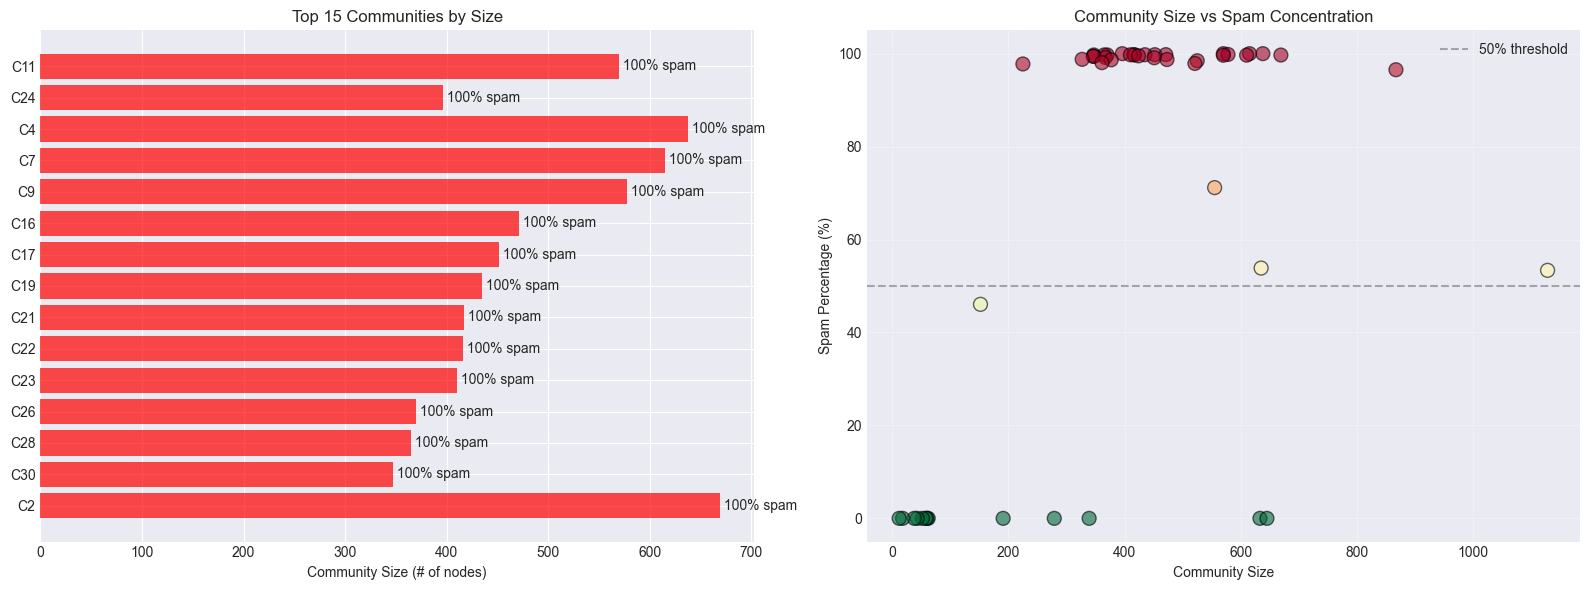


✅ Community analysis saved as 'community_analysis.png'


In [18]:
# Community Detection
print("Detecting communities in the network...")

# Convert to undirected for community detection
G_undirected = G.to_undirected()

# Get largest connected component (community detection needs connected graph)
largest_cc = max(nx.connected_components(G_undirected), key=len)
subgraph = G_undirected.subgraph(largest_cc)

print(f"Largest connected component: {len(largest_cc)} nodes")

# Detect communities using Louvain method (fast!)
from networkx.algorithms import community

communities = community.greedy_modularity_communities(subgraph)

print(f"\n{'='*60}")
print(f"COMMUNITIES DETECTED: {len(communities)}")

# Analyze each community
community_stats = []

for i, comm in enumerate(communities):
    if len(comm) < 5:  # Skip very small communities
        continue
    
    # Count spammers in this community
    spam_count = 0
    for node in comm:
        if node in features_df['sender'].values:
            is_spam = features_df[features_df['sender'] == node]['is_spammer'].values[0]
            spam_count += is_spam
    
    spam_pct = (spam_count / len(comm)) * 100
    
    community_stats.append({
        'community_id': i,
        'size': len(comm),
        'spammers': spam_count,
        'spam_pct': spam_pct
    })

comm_df = pd.DataFrame(community_stats)
comm_df = comm_df.sort_values('spam_pct', ascending=False)

print(f"\nTop 10 communities by spam concentration:")
print(comm_df.head(10).to_string(index=False))

# Visualize communities
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Community sizes
ax1 = axes[0]
comm_df_plot = comm_df.head(15)
colors = ['red' if x > 70 else 'orange' if x > 40 else 'green' 
          for x in comm_df_plot['spam_pct']]
ax1.barh(range(len(comm_df_plot)), comm_df_plot['size'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(comm_df_plot)))
ax1.set_yticklabels([f"C{i}" for i in comm_df_plot['community_id']])
ax1.set_xlabel('Community Size (# of nodes)')
ax1.set_title('Top 15 Communities by Size')
ax1.invert_yaxis()

# Add spam % labels
for idx, (size, spam_pct) in enumerate(zip(comm_df_plot['size'], comm_df_plot['spam_pct'])):
    ax1.text(size, idx, f' {spam_pct:.0f}% spam', va='center')

# 2. Spam concentration
ax2 = axes[1]
ax2.scatter(comm_df['size'], comm_df['spam_pct'], 
           c=comm_df['spam_pct'], cmap='RdYlGn_r', 
           s=100, alpha=0.6, edgecolors='black')
ax2.set_xlabel('Community Size')
ax2.set_ylabel('Spam Percentage (%)')
ax2.set_title('Community Size vs Spam Concentration')
ax2.axhline(y=50, color='black', linestyle='--', alpha=0.3, label='50% threshold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('community_analysis.png', dpi=150)
plt.show()

print("\n✅ Community analysis saved as 'community_analysis.png'")

Creating network graph with spam/ham edges...
Visualizing 303 nodes, 1056 edges
  Spam edges: 63
  Ham edges: 993


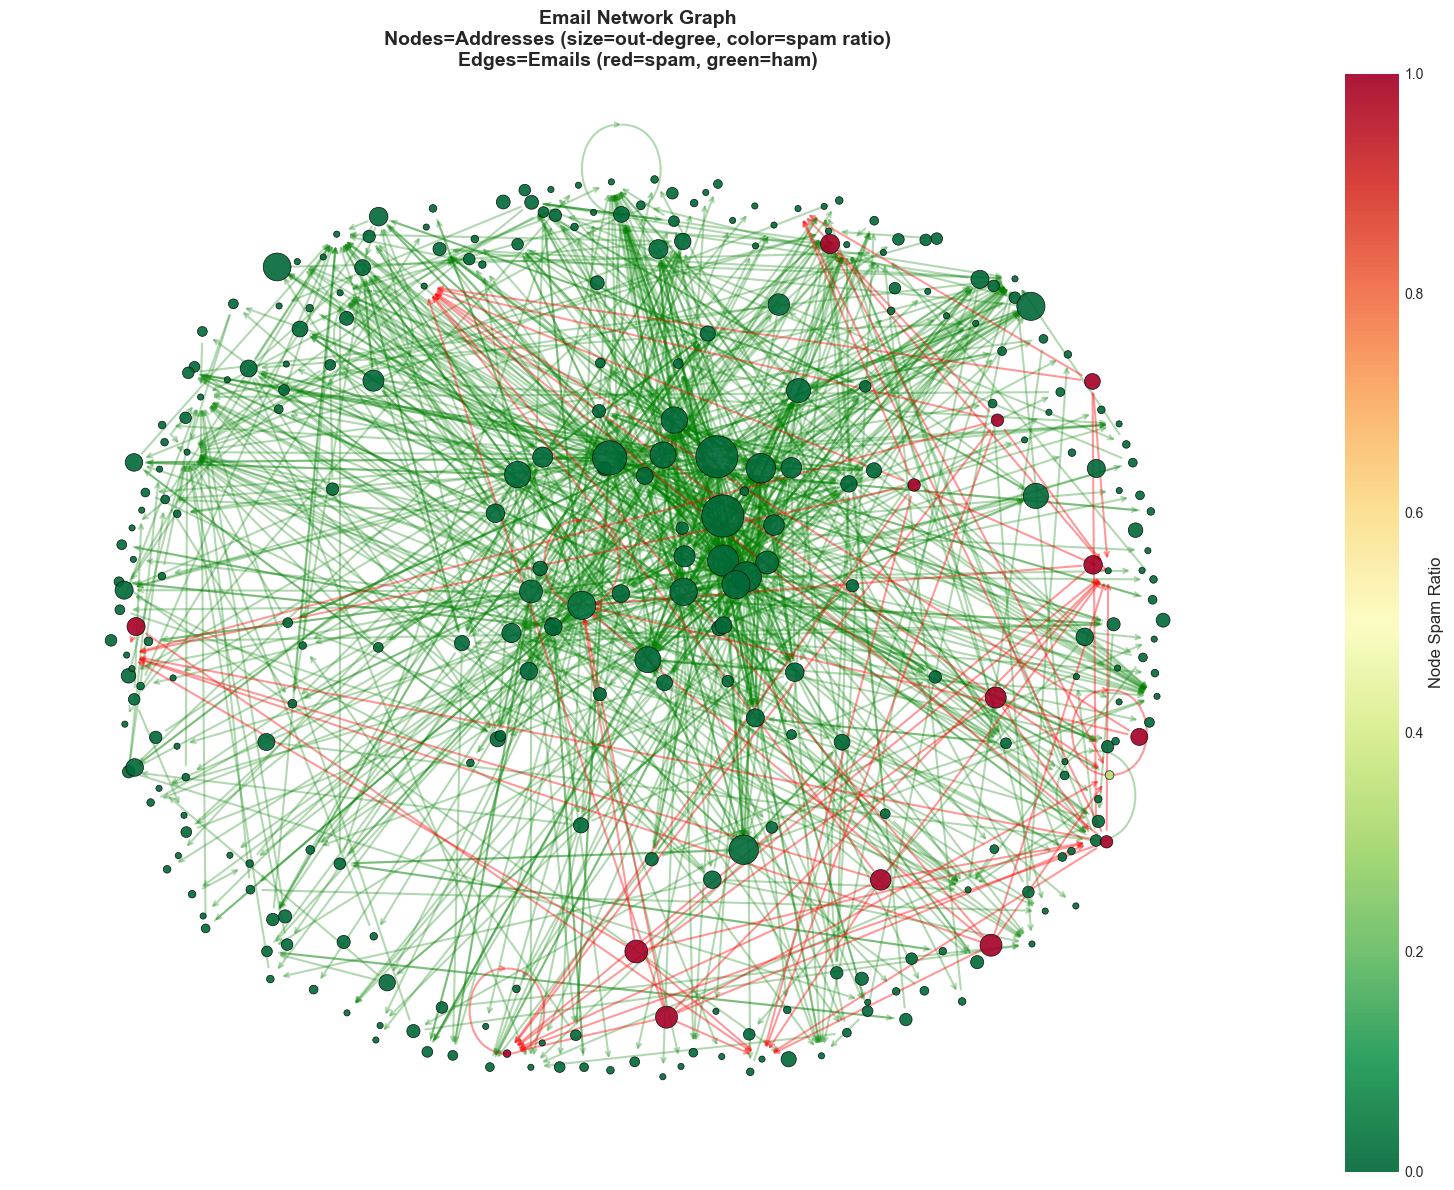


✅ Network visualization with spam/ham edges saved!


In [22]:
print("Creating network graph with spam/ham edges...")

# Take a smaller sample for clearer visualization
# Focus on nodes with high out-degree (the interesting senders)
high_degree_nodes = [n for n, d in G.out_degree() if d >= 5 and d <= 50][:100]

# Get their neighbors too
nodes_to_viz = set(high_degree_nodes)
for node in high_degree_nodes:
    nodes_to_viz.update(G.successors(node))
    if len(nodes_to_viz) > 300:  # Limit total nodes
        break

subgraph_viz = G.subgraph(list(nodes_to_viz))

print(f"Visualizing {subgraph_viz.number_of_nodes()} nodes, {subgraph_viz.number_of_edges()} edges")

# Separate edges by spam/ham
spam_edges = []
ham_edges = []

for u, v, data in subgraph_viz.edges(data=True):
    spam_count = data.get('spam_count', 0)
    ham_count = data.get('ham_count', 0)
    
    if spam_count > ham_count:
        spam_edges.append((u, v))
    else:
        ham_edges.append((u, v))

print(f"  Spam edges: {len(spam_edges)}")
print(f"  Ham edges: {len(ham_edges)}")

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Layout
pos = nx.spring_layout(subgraph_viz, k=1, iterations=50, seed=42)

# Node sizes by out-degree
node_sizes = [G.out_degree(node) * 10 + 20 for node in subgraph_viz.nodes()]

# Node colors by spam ratio
node_colors = []
for node in subgraph_viz.nodes():
    if node in features_df['sender'].values:
        spam_ratio = features_df[features_df['sender'] == node]['spam_ratio'].values[0]
        node_colors.append(spam_ratio)  # 0=green, 1=red
    else:
        node_colors.append(0)  # Receiver only = green

# Draw EDGES first (behind)
# Ham edges (green)
nx.draw_networkx_edges(subgraph_viz, pos, edgelist=ham_edges,
                       edge_color='green', alpha=0.3, arrows=True,
                       arrowsize=8, width=1.5, ax=ax, arrowstyle='->')

# Spam edges (red)
nx.draw_networkx_edges(subgraph_viz, pos, edgelist=spam_edges,
                       edge_color='red', alpha=0.4, arrows=True,
                       arrowsize=8, width=1.5, ax=ax, arrowstyle='->')

# Draw NODES on top
nodes = nx.draw_networkx_nodes(subgraph_viz, pos, 
                               node_color=node_colors,
                               node_size=node_sizes,
                               cmap='RdYlGn_r',  # Red=spam, Green=legit
                               vmin=0, vmax=1,
                               alpha=0.9, ax=ax,
                               edgecolors='black', linewidths=0.5)

# Colorbar
cbar = plt.colorbar(nodes, ax=ax)
cbar.set_label('Node Spam Ratio', fontsize=12)

ax.set_title('Email Network Graph\nNodes=Addresses (size=out-degree, color=spam ratio)\nEdges=Emails (red=spam, green=ham)', 
             fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig('network_spam_ham_edges.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n✅ Network visualization with spam/ham edges saved!")

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

print("Preparing data for machine learning...")

# Use the features we extracted earlier
X = features_df[['out_degree', 'in_degree', 'total_sent', 'reciprocity']].copy()
y = features_df['is_spammer'].copy()

# Add more graph features
print("\nAdding advanced features...")

# Feature 1: Degree ratio
X['degree_ratio'] = X['out_degree'] / (X['in_degree'] + 1)  # +1 to avoid division by zero

# Feature 2: Is isolated? (no incoming edges)
X['is_isolated'] = (X['in_degree'] == 0).astype(int)

# Feature 3: High volume flag
X['high_volume'] = (X['out_degree'] > X['out_degree'].median()).astype(int)

print("\nFeature set:")
print(X.head())
print(f"\nFeature columns: {X.columns.tolist()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n{'='*60}")
print(f"DATA SPLIT:")
print(f"  Training set: {len(X_train)} samples")
print(f"    - Spammers: {y_train.sum()}")
print(f"    - Legitimate: {(y_train == 0).sum()}")
print(f"  Test set: {len(X_test)} samples")
print(f"    - Spammers: {y_test.sum()}")
print(f"    - Legitimate: {(y_test == 0).sum()}")

Preparing data for machine learning...

Adding advanced features...

Feature set:
   out_degree  in_degree  total_sent  reciprocity  degree_ratio  is_isolated  \
0           1          0           1          0.0           1.0            1   
1           1          0           1          0.0           1.0            1   
2           1          0           1          0.0           1.0            1   
3           1          0           1          0.0           1.0            1   
4           1          0           1          0.0           1.0            1   

   high_volume  
0            0  
1            0  
2            0  
3            0  
4            0  

Feature columns: ['out_degree', 'in_degree', 'total_sent', 'reciprocity', 'degree_ratio', 'is_isolated', 'high_volume']

DATA SPLIT:
  Training set: 20968 samples
    - Spammers: 17708
    - Legitimate: 3260
  Test set: 8987 samples
    - Spammers: 7590
    - Legitimate: 1397


In [24]:
print("Training Random Forest classifier...")

# Train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train, y_train)

print("✅ Model trained!")

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of being spam

# Evaluate
print(f"\n{'='*60}")
print("MODEL PERFORMANCE:")
print(f"{'='*60}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Spammer']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(f"                 Predicted Legit  Predicted Spam")
print(f"Actually Legit:      {cm[0,0]:6d}          {cm[0,1]:6d}")
print(f"Actually Spam:       {cm[1,0]:6d}          {cm[1,1]:6d}")

# ROC AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {auc:.4f}")

# Feature Importance
print(f"\n{'='*60}")
print("FEATURE IMPORTANCE:")
print(f"{'='*60}")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))

Training Random Forest classifier...
✅ Model trained!

MODEL PERFORMANCE:

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.74      0.53      0.62      1397
     Spammer       0.92      0.97      0.94      7590

    accuracy                           0.90      8987
   macro avg       0.83      0.75      0.78      8987
weighted avg       0.89      0.90      0.89      8987


Confusion Matrix:
                 Predicted Legit  Predicted Spam
Actually Legit:         742             655
Actually Spam:          254            7336

ROC AUC Score: 0.7559

FEATURE IMPORTANCE:
     feature  importance
  total_sent    0.597019
  out_degree    0.097244
 is_isolated    0.091702
 high_volume    0.082894
   in_degree    0.063973
degree_ratio    0.052826
 reciprocity    0.014341
